In [2]:
import rasterio
import rasterio.features
import rasterio.warp
import os
import glob
from geojson import Point, Feature, FeatureCollection, dump
import geopandas as gpd
import pandas as pd
import shapely.wkt

In [9]:
# define inputs
sensor = "sen2"
root_dir = "/home/simon/CDE_UBS/thesis/data_collection/"
out_fp = root_dir + "footprints"
path = root_dir + sensor + "/date_mosaics"



# define search criteria automatically based on sensor
if sensor == "spot6":
    search_criteria = "*.jp2"
if sensor == "sen2":
    search_criteria = "merged*.tif"
search_term = os.path.join(path, search_criteria)
# perform search
files = glob.glob(search_term)


In [10]:
files

['/home/simon/CDE_UBS/thesis/data_collection/sen2/date_mosaics/merged_reprojected20180519_mosaic.tif',
 '/home/simon/CDE_UBS/thesis/data_collection/sen2/date_mosaics/merged_reprojected20180629_mosaic.tif',
 '/home/simon/CDE_UBS/thesis/data_collection/sen2/date_mosaics/merged_reprojected20180927_mosaic.tif',
 '/home/simon/CDE_UBS/thesis/data_collection/sen2/date_mosaics/merged_reprojected20180708_mosaic.tif',
 '/home/simon/CDE_UBS/thesis/data_collection/sen2/date_mosaics/merged_reprojected20180902_mosaic.tif',
 '/home/simon/CDE_UBS/thesis/data_collection/sen2/date_mosaics/merged_reprojected20180707_mosaic.tif',
 '/home/simon/CDE_UBS/thesis/data_collection/sen2/date_mosaics/merged_reprojected20180622_mosaic.tif',
 '/home/simon/CDE_UBS/thesis/data_collection/sen2/date_mosaics/merged_reprojected20180722_mosaic.tif',
 '/home/simon/CDE_UBS/thesis/data_collection/sen2/date_mosaics/merged_reprojected20180726_mosaic.tif',
 '/home/simon/CDE_UBS/thesis/data_collection/sen2/date_mosaics/merged_rep

In [16]:
names = []
geoms = []

# Extract Footprints
counter = 0
for i in files:
    # def counter cond
    counter = counter+1
    if counter%1==0:
        perc = 100 * float(counter)/float(len(files))
        print(str(int(perc))+"%","       ",end="\r")
    
    
    file_name = i[i.rfind("/")+1:i.rfind(".")]
    #print(file_name)
    out_name = out_fp + file_name+".GeoJSON"
    #print(out_name)
    
    with rasterio.open(i) as dataset:

        # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()

        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            #geom = rasterio.warp.transform_geom(
            #    dataset.crs, 'EPSG:4326', geom, precision=6)

            # Print GeoJSON shapes to stdout.
            n = out_name[out_name.rfind("/")+1:out_name.rfind(".")] + ".jp2"
            n = n.replace("footprints","")
            names.append(n)
            geoms.append(geom)

In [17]:
# Modify WKT to be able to pass into GDF
wkt_geoms = []
for v,i in enumerate(geoms):
    coordinates = i["coordinates"]
    wkt_str = "POLYGON (("
    for coor in coordinates:
        for x in coor:
            wkt_str=wkt_str+""
            x_1 = str(x).replace(",","")
            x_1 = x_1.replace("(","")
            x_1 = x_1.replace(")","")
            x_1 = x_1.replace(".0","")
            wkt_str = wkt_str+x_1+","
        wkt_str = wkt_str[:wkt_str.rfind(",")] + wkt_str[wkt_str.rfind(",")+1:]
            
    wkt_str = wkt_str.replace("[","")
    wkt_str = wkt_str.replace("]","")
    wkt_str = wkt_str+"))"
    #print(wkt_str)
    wkt_geoms.append(shapely.wkt.loads(wkt_str))

df = pd.DataFrame()
df["name"] = names
df["geom"] = wkt_geoms
gdf = gpd.GeoDataFrame(df, geometry=df.geom)

In [18]:
gdf.set_crs(epsg=2154)
gdf = gdf[["name","geometry"]]
#gdf.to_file(out_fp+"/footprints_"+sensor+"_4326.shp")

<AxesSubplot:>

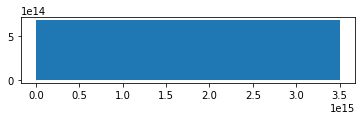

In [19]:
gdf.plot()